## Setup

In [1]:
! pip install neuralogic
from neuralogic.nn import get_evaluator
from neuralogic.core import R, Template, V, Transformation, Aggregation
from neuralogic.core.settings import Settings
from neuralogic.dataset import Dataset
from neuralogic.optim import SGD
from neuralogic.utils.data import Mutagenesis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 34.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.3/465.3 KB 17.2 MB/s eta 0:00:00


/usr/local/lib/python3.9/dist-packages/neuralogic/core/builder/builder.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


## Dataset definition

In [6]:
_, dataset = Mutagenesis()

template = Template()

template.add_rules([
    (R.atom_embed(V.A)[3,] <= R.get(atom)(V.A)) for atom in ["c", "o", "br", "i", "f", "h", "n", "cl"]
])


template.add_rules([
    (R.bond_embed(V.B)[3,] <= R.get(bond)(V.B)) for bond in ["b_1", "b_2", "b_3", "b_4", "b_5", "b_7"]
])





## Diffusion CNNs


In [7]:
def get_path(max_depth:int, layer_name: str, edge_embed: str, connection: str, param_size: tuple):
  template = []
  template += [R.get(layer_name)(V.X, V.Y, 0) <= (R.get(edge_embed)(V.B)[param_size], R.get(connection)(V.X, V.Y, V.B)) ]
  template += [R.get(layer_name)(V.X, V.Y, V.T) <= (R.get(edge_embed)(V.B)[param_size], 
                                         R.get(layer_name)(V.Z, V.Y, V.T1)[param_size], 
                                         R.get(connection)(V.X, V.Z, V.B),
                                         R.special.next(V.T1, V.T))]
  for i in range(max_depth):
    template += [(R._next(i, i + 1))]

  template += [R.get(layer_name)(V.X, V.Y) <= (R.get(layer_name)(V.X, V.Y, max_depth))]
    
  return template

def get_diffusion(layer_name: str, path_name: str, node_embed: str, param_size: tuple):
  template = []
  template += [(R.get(layer_name + "_Z")(V.X) <= (R.get(path_name)(V.X, V.Y), R.get(node_embed)(V.Y)[param_size])) | [Aggregation.SUM]]
  template += [R.get(layer_name + "_Z")(V.X) <= R.get(node_embed)(V.X)[param_size]]
  template += [(R.get(layer_name)(V.X) <= (R.get(layer_name + "_Z")(V.X))) | [Transformation.SIGMOID, Aggregation.SUM]]

  return template

template += get_path(5, "path", "bond_embed", "bond", (3, 3))
template += get_diffusion("l1", "path", "atom_embed", (3, 3))

template += R.predict[1, 3] <= R.l1(V.X)



In [ ]:
########### CONTROL #############

template += R.path(V.X, V.Y, 0) <= (R.bond_embed(V.B)[3, 3], R._bond(V.X, V.Y, V.B)) 
template += R.path(V.X, V.Y, V.T) <= (R.bond_embed(V.B)[3, 3], R.path(V.Z, V.Y, V.T1)[3, 3], R._bond(V.X, V.Z, V.B), R.special.next(V.T1, V.T))

max_depth = 5


template += (R.Z(V.X) <= (R.path(V.X, V.Y, max_depth), R.atom_embed(V.Y)[3, 3])) | [Aggregation.SUM]
template += R.Z(V.X) <= R.atom_embed(V.X)[3, 3]

#next layer
template += (R.Z1(V.X) <= (R.path(V.X, V.Y, max_depth), R.Z(V.Y)[3, 3])) | [Aggregation.SUM]
template += R.Z1(V.X) <= R.Z(V.X)[3, 3]

template += (R._next(i, i + 1) for i in range(max_depth +1))
template += (R.predict[1, 3] <= (R.Z1(V.X))) | [Transformation.SIGMOID, Aggregation.SUM]

{3} atom_embed(A) :- c(A).
{3} atom_embed(A) :- o(A).
{3} atom_embed(A) :- br(A).
{3} atom_embed(A) :- i(A).
{3} atom_embed(A) :- f(A).
{3} atom_embed(A) :- h(A).
{3} atom_embed(A) :- n(A).
{3} atom_embed(A) :- cl(A).
{3} bond_embed(B) :- b_1(B).
{3} bond_embed(B) :- b_2(B).
{3} bond_embed(B) :- b_3(B).
{3} bond_embed(B) :- b_4(B).
{3} bond_embed(B) :- b_5(B).
{3} bond_embed(B) :- b_7(B).
path(X, Y, 0) :- {3, 3} bond_embed(B), bond(X, Y, B).
path(X, Y, T) :- {3, 3} bond_embed(B), {3, 3} path(Z, Y, T1), bond(X, Z, B), @next(T1, T).
*next(0, 1).
*next(1, 2).
*next(2, 3).
*next(3, 4).
*next(4, 5).
path(X, Y) :- path(X, Y, 5).
l1_Z(X) :- path(X, Y), {3, 3} atom_embed(Y). [aggregation=sum]
l1_Z(X) :- {3, 3} atom_embed(X).
l1(X) :- l1_Z(X). [transformation=sigmoid, aggregation=sum]
{1, 3} predict :- l1(X).


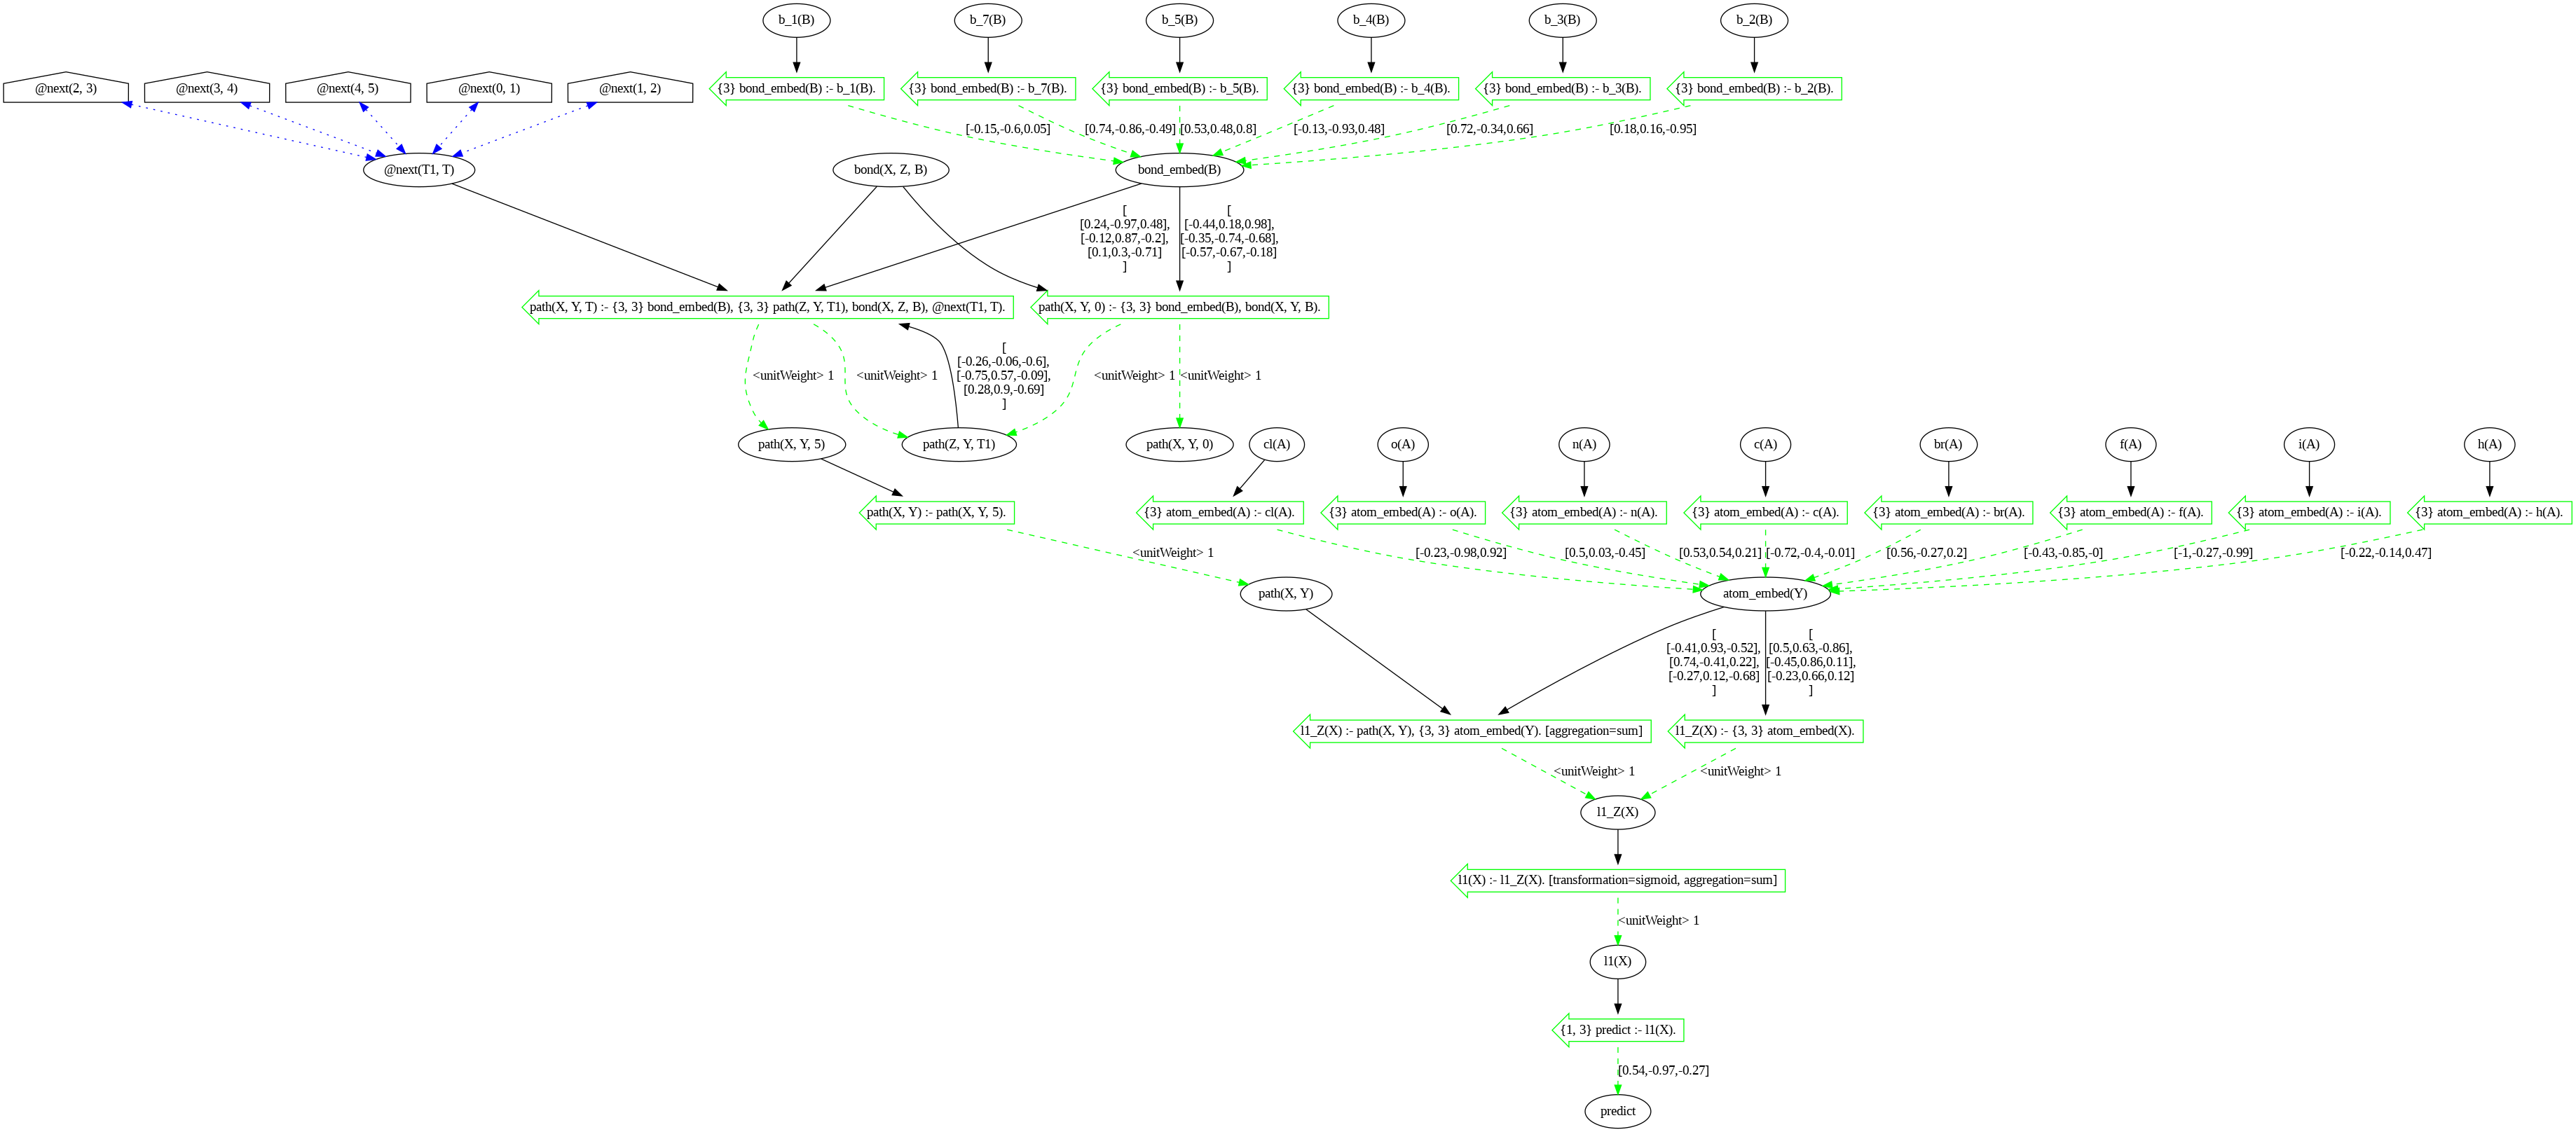

In [8]:
print(template)
template.draw()

## Training

In [9]:
from neuralogic.core import Settings
from neuralogic.nn.loss import MSE
from neuralogic.nn import get_evaluator
from neuralogic.optim import Adam
import random
import numpy as np
from IPython.display import clear_output
import matplotlib.pyplot as plt

def train_test_cycle(template, dataset, lr=0.001, epochs=100, split=0.75):
  settings = Settings(optimizer=Adam(lr=lr), epochs=epochs, error_function=MSE())
  evaluator = get_evaluator(template, settings)

  built_dataset = evaluator.build_dataset(dataset)
  dataset_len = len(built_dataset.samples)

  train_size = int(dataset_len*split)

  idx = random.sample(list(range(dataset_len)), train_size)
  rest = list(set(range(dataset_len)) - set(idx))
  train_dataset = np.array(built_dataset.samples)[idx]
  test_dataset = np.array(built_dataset.samples)[rest]
  average_losses = []

  for current_total_loss, number_of_samples in evaluator.train(train_dataset):
      clear_output(wait=True)
      plt.ylabel("Loss")
      plt.xlabel("Epoch")

      plt.xlim(0, settings.epochs)
      
      train_loss = current_total_loss/number_of_samples
      print(train_loss)

      average_losses.append(train_loss)
      
      plt.plot(average_losses, label="Average loss")

      plt.legend()
      plt.pause(0.001)
      plt.show()

  loss = []
  for sample, y_hat in zip(test_dataset, evaluator.test(test_dataset, generator=False)):
      loss.append(round(y_hat) != sample.java_sample.target.value)

  test_loss = sum(loss) / len(test_dataset)

  return train_loss, test_loss, evaluator


0.09854651732623951


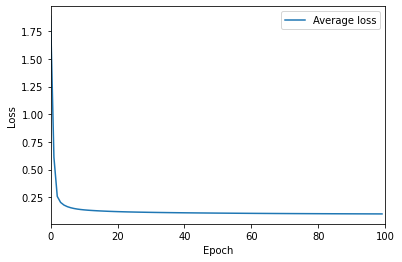

0.1702127659574468

In [10]:
test_losses = []
for i in range(1):
  print("Training and testing model #{}".format(i))
  train_loss, test_loss, eval = train_test_cycle(template, dataset)
  test_losses.append(test_loss)

np.average(test_losses)